In [1]:
import numpy as np
from scipy.stats import uniform, randint
from time import time

# plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# dataset
from sklearn.datasets import make_moons, make_classification

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# result metrics
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

# ensemble meta-classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

### Global parameters

In [2]:
MESH_STEP = 0.02
N_SAMPLES = 500
DATA_NOISE = 0.2
TEST_SIZE = 0.2

### Preprocess dataset

In [3]:
dataset = make_moons(n_samples=N_SAMPLES, noise=DATA_NOISE)

In [4]:
X, y = dataset
X = StandardScaler().fit_transform(X)
dataset_split = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = dataset_split

In [5]:
def graph_limits(dataset_split):
    """
    Returns the x-axis and y-axis limits for the dataset
    """
    X_train, X_test, y_train, y_test = dataset_split
    
    # x-axis limits
    x_min = min( X_train[:, 0].min(), X_test[:, 0].min() ) - 0.5
    x_max = max( X_train[:, 0].max(), X_test[:, 0].max()) + 0.5
    # y-axis limits (not y the category!)
    y_min = min( X_train[:, 1].min(), X_test[:, 1].min() ) - 0.5
    y_max = max( X_train[:, 1].max(), X_test[:, 1].max() ) + 0.5
    
    return x_min, x_max, y_min, y_max    

def scatter_datapoints(ax, dataset_split):
    X_train, X_test, y_train, y_test = dataset_split
    cmap = ListedColormap(['r', 'b'])

    # Plot the training points (as regular points)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, edgecolors='k')
    # Plot the testing points (as '*')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, s=300, marker='*', edgecolors='k')

def plot_dataset(dataset_split):
    figure = plt.figure(figsize=(27, 9))
    ax = plt.axes()

    x_min, x_max, y_min, y_max = graph_limits(dataset_split)

    scatter_datapoints(ax, dataset_split)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def compare_classifiers_plot(dataset_split, classifiers, clf_names):
    """
    Plot decision boundaries for a set of classifiers and compare their respective accuracies
    """
    X_train, X_test, y_train, y_test = dataset_split
    
    fig = plt.figure(figsize=(20, 35))
    plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
    
    nrows = int(np.ceil(len(classifiers)/2))
    ncols = 3
    
    for (i, (clf_name, clf)) in enumerate(zip(clf_names, classifiers)):
        # timer for training
        t0 = time()
        clf.fit(X_train, y_train)
        train_time = time()-t0
        
        y_pred_in = clf.predict(X_train)
        y_pred = clf.predict(X_test)

        ax = plt.subplot(nrows, ncols, i+1)
        
        # show datapoints
        scatter_datapoints(ax, dataset_split)

        x_min, x_max, y_min, y_max = graph_limits(dataset_split)

        xx, yy = np.meshgrid(np.arange(x_min, x_max, MESH_STEP),
                             np.arange(y_min, y_max, MESH_STEP))

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh based on the likehood of correct classification
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

        in_acc = accuracy_score(y_train, y_pred_in)
        out_acc = accuracy_score(y_test, y_pred)

        # print accuracy of each classifier, and in case of a cv random search,
        # the value of the optimal hyperparameters
        xlabel ='{}\nIn: {:.2%}\nOut: {:.2%}'.format(clf_name, in_acc, out_acc)
        if hasattr(clf, "best_params_"):
            for param, value in clf.best_params_.items():
                xlabel += '\n{}: {}'.format(param, value)
        
        # print training time
        xlabel += '\nTraining time: {:.3f}s'.format(train_time)
        plt.xlabel(xlabel, fontsize=14)

    plt.tight_layout()
    plt.show()

### Classifiers

In [7]:
MIN_SAMPLE_LEAF = 1
MAX_DEPTH = 5
MAX_LEAF_NODES= 8
N_ESTIMATORS = 200
MAX_SAMPLES = 50
N_ITER_SEARCH = 10
CV = 5

In [8]:
log_clf = LogisticRegression(solver='lbfgs')

knn_clf = RandomizedSearchCV(
    KNeighborsClassifier(
        weights='distance', 
        n_jobs=-1
    ),
    param_distributions={'n_neighbors': randint(1,30)},
    n_iter=N_ITER_SEARCH, 
    cv=CV,
    iid=False,
)

decision_tree_clf = DecisionTreeClassifier(
    max_leaf_nodes=MAX_LEAF_NODES, 
    max_depth=MAX_DEPTH, 
    min_samples_leaf=MIN_SAMPLE_LEAF
)

random_forest_clf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, 
    max_leaf_nodes=MAX_LEAF_NODES, 
    n_jobs=-1
) # n_jobs=-1 : use all available CPU cores

# use cross-validated version in ordere to predict probabilities as well
lin_svm_clf = CalibratedClassifierCV(
    base_estimator=LinearSVC(),
    cv=CV
)

sigm_svm_clf = RandomizedSearchCV(
    SVC(
        kernel='sigmoid',
        gamma='scale',
        probability=True
    ),
    param_distributions={'coef0': uniform(0,6)},
    n_iter=N_ITER_SEARCH, 
    cv=CV,
    iid=False,
)

rbf_svm_clf = CalibratedClassifierCV(
    SVC(
        kernel='rbf',
        gamma='scale',
        probability=True
    ),
    cv=CV
)

In [9]:
classifiers = [
    log_clf,
    lin_svm_clf,
    sigm_svm_clf,
    rbf_svm_clf,
    knn_clf,
    decision_tree_clf,
    random_forest_clf,
]

clf_names = [
    'Logistic Regression',
    'Linear SVM',
    'Sigmoid SVM',
    'Gaussian SVM',
    'KNN',
    'Decision Tree',
    'Random Forest',
]

best_classifiers = [
    rbf_svm_clf,
    random_forest_clf,
]

best_clf_names = [
    'Gaussian SVM',
    'Random Forest',
]

### Ensemble Classifiers

In [10]:
decision_tree_bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    max_samples=MAX_SAMPLES,
    bootstrap=True,
    n_jobs=-1,
)

# all classifiers get to vote
demo_soft_voting_clf = VotingClassifier(
    estimators=list(zip(clf_names, classifiers)),
    voting='soft',
)

# only rbf_svm and random forests get to vote
oli_soft_voting_clf = VotingClassifier(
    estimators=list(zip(best_clf_names, best_classifiers)),
    voting='soft',
)

decision_tree_ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    algorithm='SAMME.R',
    learning_rate=0.5,
)

In [11]:
ens_classifiers = [
    demo_soft_voting_clf,
    oli_soft_voting_clf,
    decision_tree_bag_clf,
    decision_tree_ada_clf
]

ens_clf_names = [
    'Democratic Soft Voting',
    'Oligarchic Soft Voting',
    'Decision Tree Bagging',
    'Decision Tree Boosting',
]

## Compare them all

In [12]:
all_classifiers = classifiers+ens_classifiers
all_clf_names = clf_names+ens_clf_names

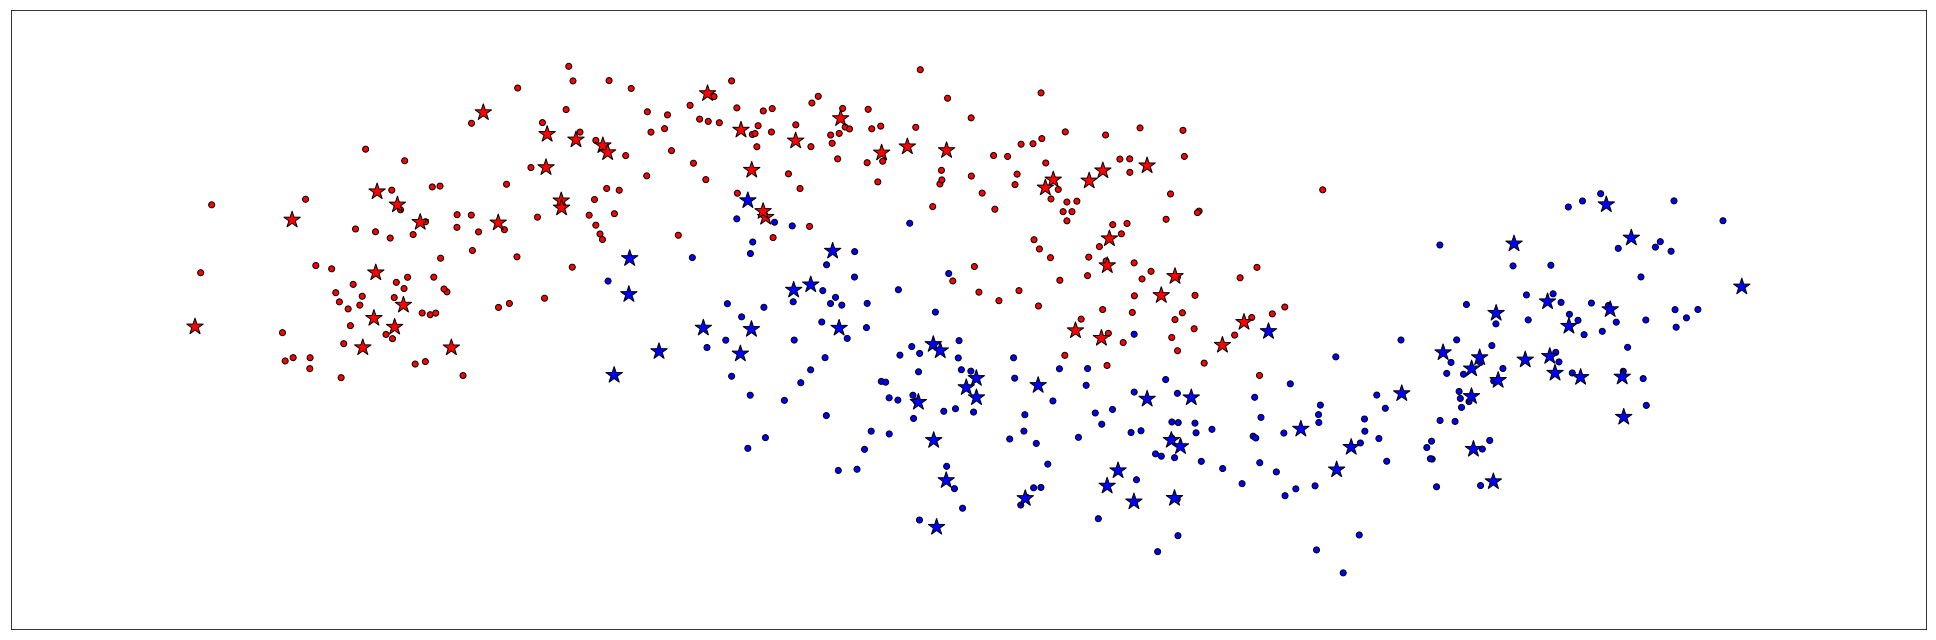

In [13]:
plot_dataset(dataset_split)

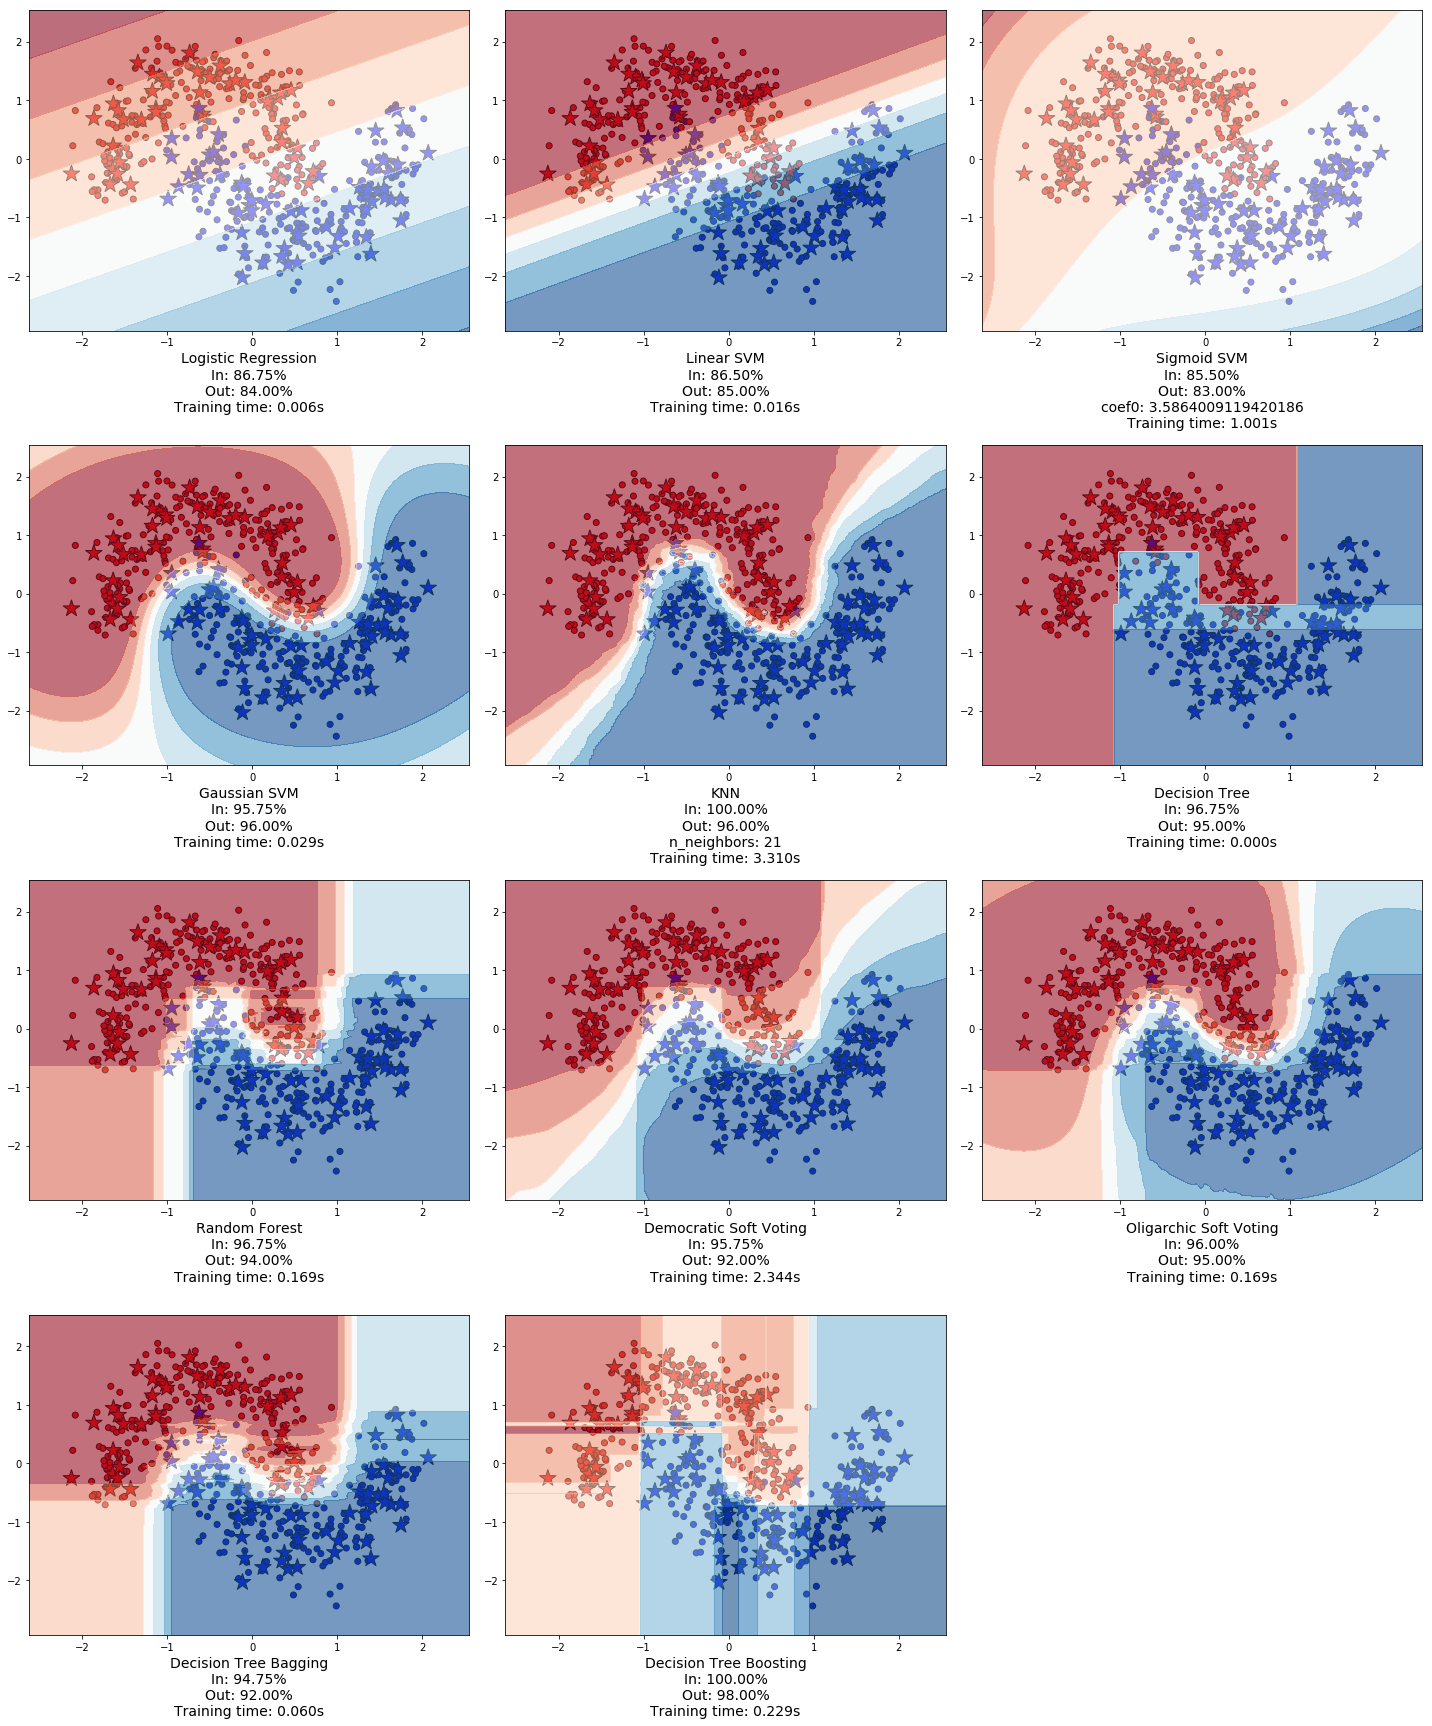

In [14]:
compare_classifiers_plot(dataset_split, all_classifiers, all_clf_names)

## Redo the experiment with more noise

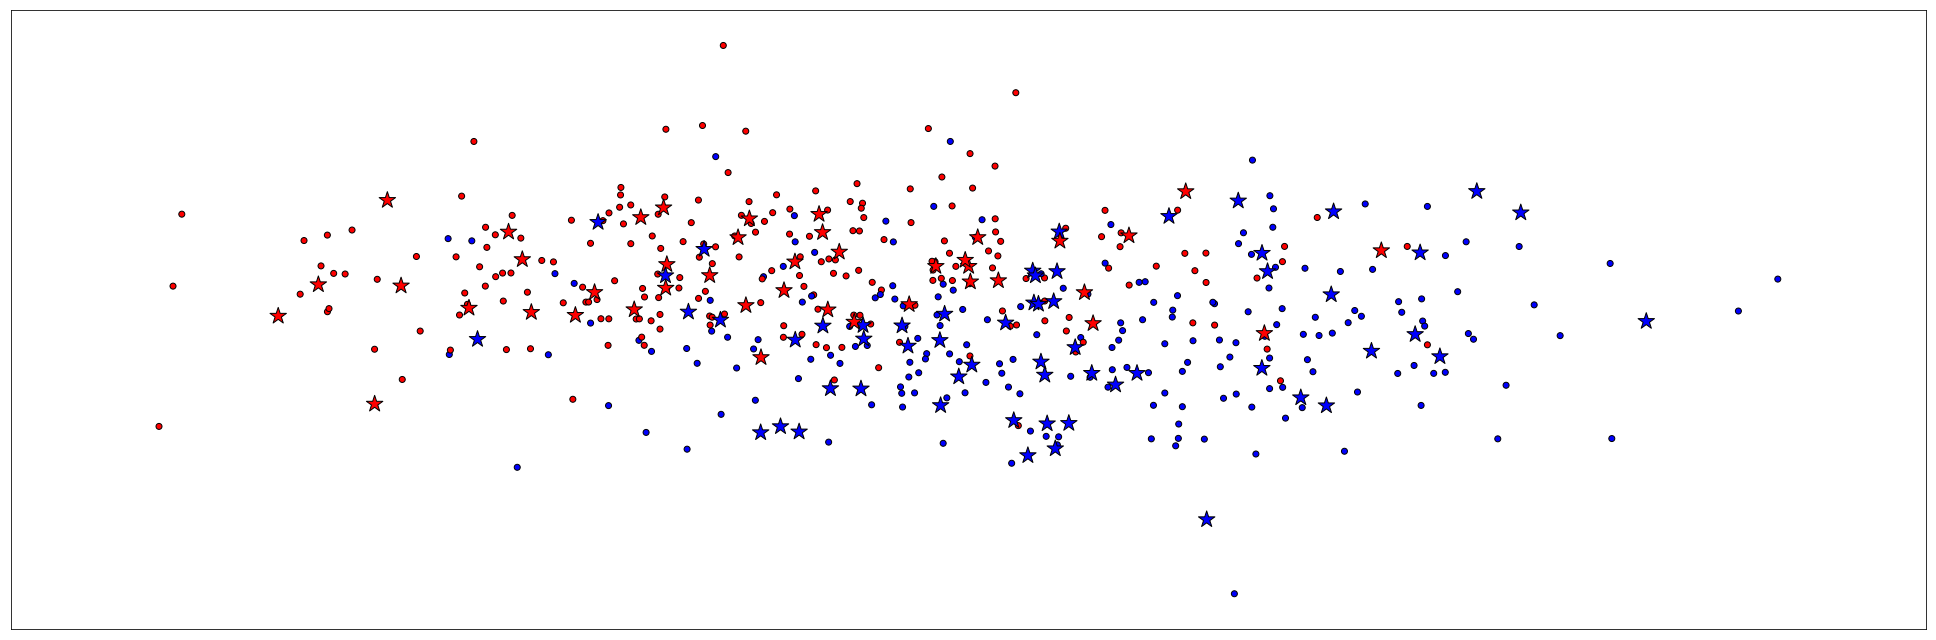

In [15]:
DATA_NOISE = 0.6
dataset = make_moons(n_samples=N_SAMPLES, noise=DATA_NOISE)
X, y = dataset
X = StandardScaler().fit_transform(X)
dataset_split = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = dataset_split
plot_dataset(dataset_split)

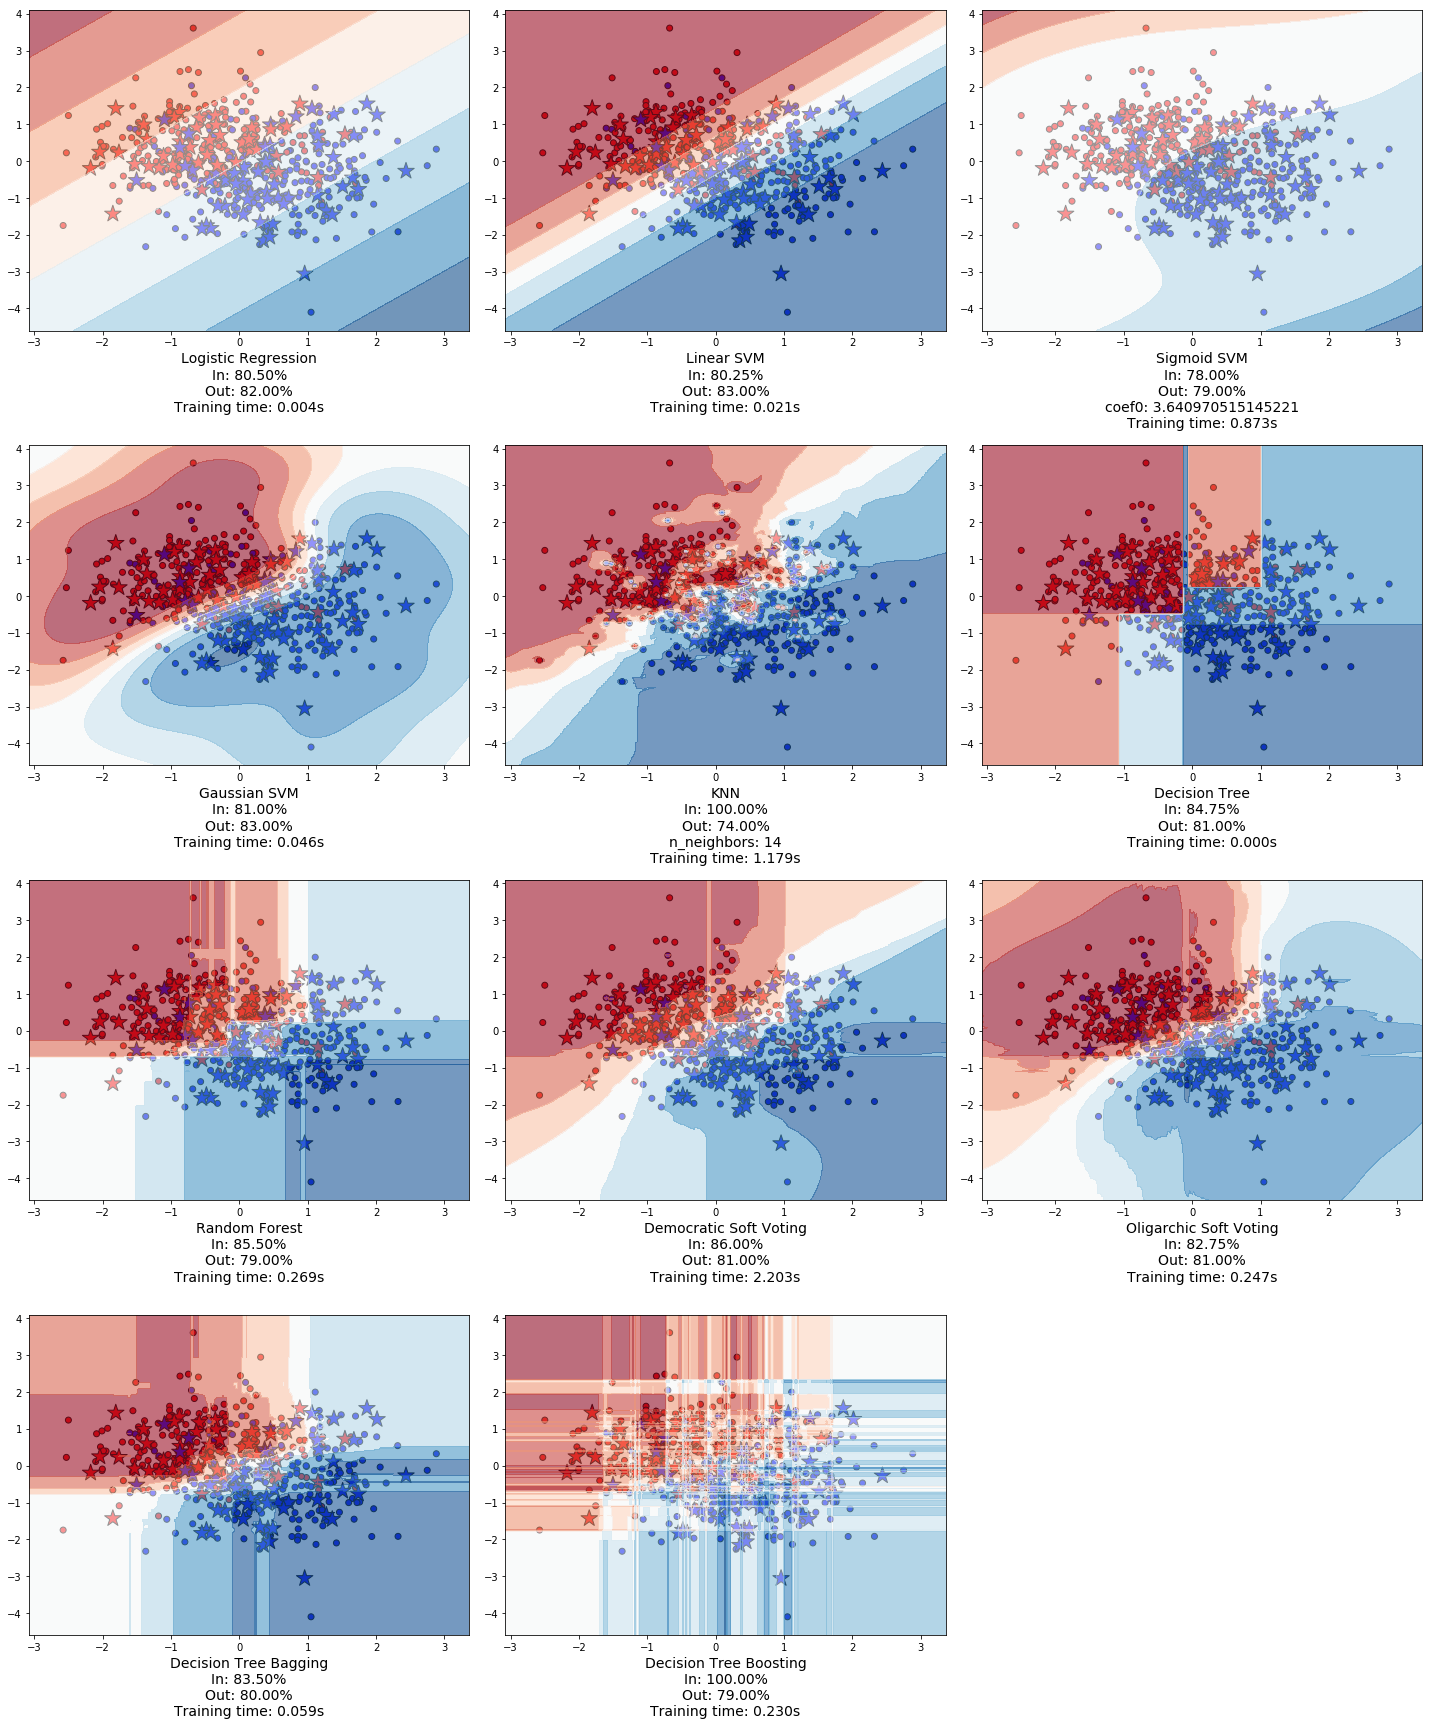

In [16]:
all_classifiers = classifiers+ens_classifiers
all_clf_names = clf_names+ens_clf_names
compare_classifiers_plot(dataset_split, all_classifiers, all_clf_names)

* **Logistic Regression, Linear SVM** : limited expressiveness due to linear decision boundaries, therefore low accuracy, but robust to overfitting.
* **Sigmoid SVM** : slight overfitting, requires hyperparameter tuning to achieve good accuracy, but the hyperparameter and therefore the shape of the decision boundaries are very sensible to noise. This kernel is not appropriate for this dataset.
* **Gaussian (RBF) SVM** : no overfitting, good accuracy without hyperparameter tuning. Smooth decision boundaries. Appropriate kernel.
* **KNN** : overfitting, but overall good accuracy.
* **Decision Tree, Random Forest** : slight overfitting but good accuracy, simple decision boundaries.
* **Voting classifiers** : overfit if the base classifiers do, hence Oligarchic Voting is better. Best accuracy.
* **Tree Bagging** : enhances the accuracy of decision trees while reducing overfitting.
* **Tree Boosting** : massive overfitting, 100% in-sample accuracy but poor out-of-sample performance. Very sensible to noise (goes from best to worst classifier when trained on noisier signals).